<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

Bitcoin:
https://finance.yahoo.com/quote/BTC-USD/history?period1=1410825600&period2=1699142400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

Apple:
https://finance.yahoo.com/quote/AAPL/history?period1=345427200&period2=1699142400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

Microsoft:
https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1699142400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

## Load Dataset and Preprocess It:

In [75]:
import pandas as pd

# Bitcoin
# df = pd.read_csv("BTC-USD.csv")
# df = df[["Date", "Adj Close"]]
# df.rename(columns = {"Adj Close" : "Price"}, inplace = True)

# Apple
# df = pd.read_csv("AAPL.csv")
# df = df[["Date", "Adj Close"]]
# df.rename(columns = {"Adj Close" : "Price"}, inplace = True)

# S&P 500
df = pd.read_csv("sp500_index.csv")
df.rename(columns = {"S&P500" : "Price"}, inplace = True)

# Microsoft
# df = pd.read_csv("MSFT.csv")
# df = df[["Date", "Adj Close"]]
# df.rename(columns = {"Adj Close" : "Price"}, inplace = True)

df

,Date,Price
0,2013-11-04,1767.93
1,2013-11-05,1762.97
2,2013-11-06,1770.49
3,2013-11-07,1747.15
4,2013-11-08,1770.61
...,...,...
2513,2023-10-30,4166.82
2514,2023-10-31,4193.80
2515,2023-11-01,4237.86
2516,2023-11-02,4317.78


In [76]:
import datetime

def str_to_datetime(s):
  year, month, day = [int(i) for i in s.split('-')]
  return datetime.datetime(year=year, month=month, day=day)

# Convert date type objects to datetime object
df["Date"] = df["Date"].apply(str_to_datetime)

# Turn Date into dataframe index
df.index = df.pop("Date")

df

,Price
Date,
2013-11-04,1767.93
2013-11-05,1762.97
2013-11-06,1770.49
2013-11-07,1747.15
2013-11-08,1770.61
...,...
2023-10-30,4166.82
2023-10-31,4193.80
2023-11-01,4237.86


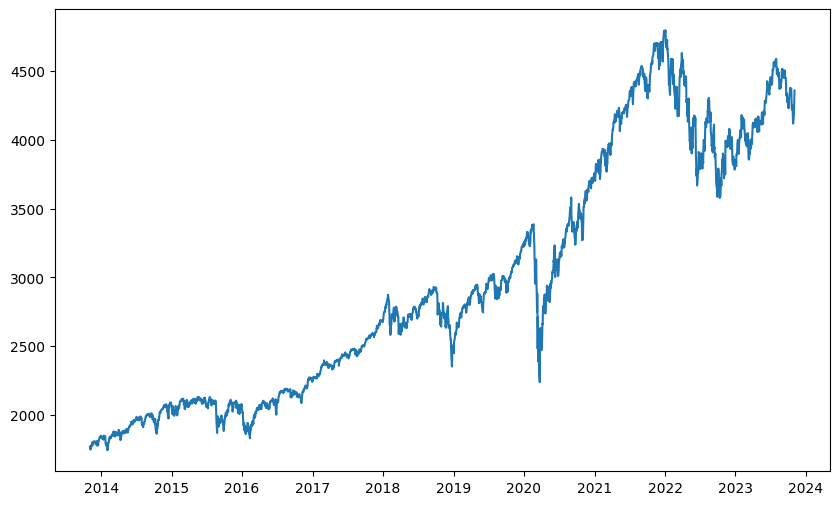

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])

In [78]:
# numbers of days to consider in the input of the model
lookback = 7 # a single week

def df_to_windowed(df, n=lookback):
  data = pd.DataFrame()
  for i in range(n, 0, -1):
    data[f"Last-{i} Price"] = df["Price"].shift(periods=i)
  data["Price"] = df["Price"]
  return data.dropna()

# Convert to a windowed Dataframe,
# so the last day prices (input) can predict the next day price (output)
windowed_df = df_to_windowed(df)

# Choose the amount of days to consider
days = 500

windowed_df = windowed_df[-days:]

windowed_df

,Last-7 Price,Last-6 Price,Last-5 Price,Last-4 Price,Last-3 Price,Last-2 Price,Last-1 Price,Price
Date,,,,,,,,
2021-11-09,4605.38,4613.67,4630.65,4660.57,4680.06,4697.53,4701.70,4685.25
2021-11-10,4613.67,4630.65,4660.57,4680.06,4697.53,4701.70,4685.25,4646.71
2021-11-11,4630.65,4660.57,4680.06,4697.53,4701.70,4685.25,4646.71,4649.27
2021-11-12,4660.57,4680.06,4697.53,4701.70,4685.25,4646.71,4649.27,4682.85
2021-11-15,4680.06,4697.53,4701.70,4685.25,4646.71,4649.27,4682.85,4682.80
...,...,...,...,...,...,...,...,...
2023-10-30,4278.00,4224.16,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82
2023-10-31,4224.16,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82,4193.80
2023-11-01,4217.04,4247.68,4186.77,4137.23,4117.37,4166.82,4193.80,4237.86


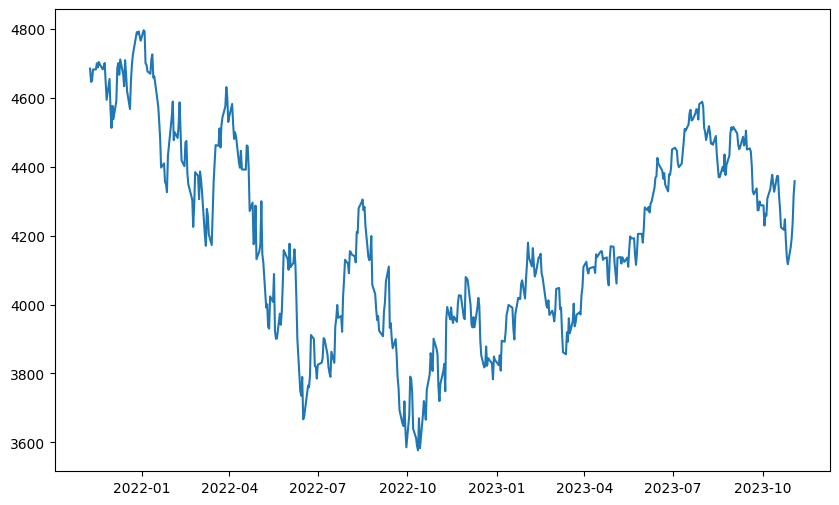

In [79]:
plt.figure(figsize=(10,6))
plt.plot(windowed_df.index, windowed_df["Price"])

In [80]:
from sklearn.preprocessing import MinMaxScaler

min_max = (df["Price"].min(), df["Price"].max())
scaler = MinMaxScaler(feature_range=(0, 1))

def split_normalize_dataframe(windowed_df):
  dates = windowed_df.index.to_numpy()

  df_scaled = scaler.fit_transform(windowed_df)

  X = df_scaled[:, :-1]
  Y = df_scaled[:, -1]

  return dates, X, Y

# Split dataframe into numpy arrays for the index, input and output
# and fit values into [0, 1] range
dates, X, Y = split_normalize_dataframe(windowed_df)

dates.shape, X.shape, Y.shape

((500,), (500, 7), (500,))

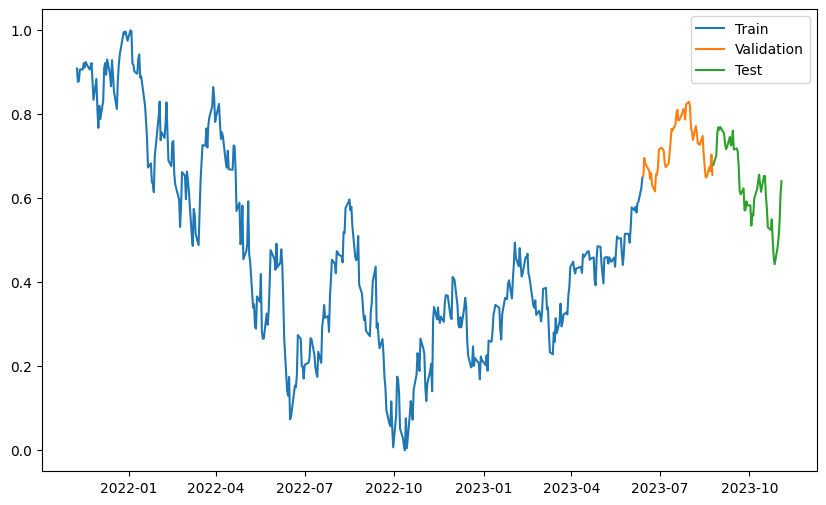

In [81]:
# Separate data into 80% training, 10% validation and 10% test
q80 = int(len(dates) * .8)
q90 = int(len(dates) * .9)

dates_train, X_train, Y_train = dates[:q80], X[:q80], Y[:q80]
dates_val, X_val, Y_val = dates[q80:q90], X[q80:q90], Y[q80:q90]
dates_test, X_test, Y_test = dates[q90:], X[q90:], Y[q90:]

plt.figure(figsize=(10,6))
plt.plot(dates_train, Y_train)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, Y_test)
plt.legend(["Train", "Validation", "Test"])

## Model Training

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, backend

model = Sequential([
    layers.Input((lookback, 1)),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.05), # to avoid overfitting
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.05), # to avoid overfitting
    layers.Dense(1)
  ])

model.compile(
    loss="mse", # mean square error
    optimizer=Adam(learning_rate=0.0001),
    metrics=["mean_absolute_error"] # extra metrics
  )

model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)

Epoch 1/50
13/13 [==============================] - 4s 60ms/step - loss: 0.2319 - mean_absolute_error: 0.4261 - val_loss: 0.4026 - val_mean_absolute_error: 0.6322
Epoch 2/50
13/13 [==============================] - 0s 19ms/step - loss: 0.1905 - mean_absolute_error: 0.3826 - val_loss: 0.3269 - val_mean_absolute_error: 0.5695
Epoch 3/50
13/13 [==============================] - 0s 19ms/step - loss: 0.1478 - mean_absolute_error: 0.3343 - val_loss: 0.2490 - val_mean_absolute_error: 0.4967
Epoch 4/50
13/13 [==============================] - 0s 19ms/step - loss: 0.1061 - mean_absolute_error: 0.2775 - val_loss: 0.1671 - val_mean_absolute_error: 0.4064
Epoch 5/50
13/13 [==============================] - 0s 20ms/step - loss: 0.0644 - mean_absolute_error: 0.2104 - val_loss: 0.0896 - val_mean_absolute_error: 0.2965
Epoch 6/50
13/13 [==============================] - 0s 19ms/step - loss: 0.0295 - mean_absolute_error: 0.1368 - val_loss: 0.0317 - val_mean_absolute_error: 0.1739
Epoch 7/50
13/13 [====

## Results

In [83]:
def denormalize(val):
  mn, mx = min_max
  return val * (mx - mn) + mn

13/13 [==============================] - 1s 5ms/step


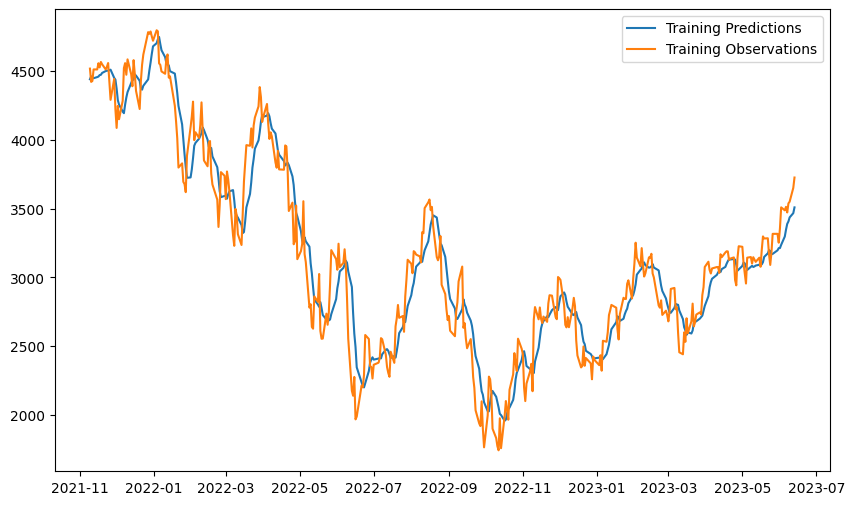

In [84]:
train_predictions = model.predict(X_train)

train_predictions = pd.DataFrame(train_predictions).apply(denormalize)
Y_train = pd.DataFrame(Y_train).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.legend(["Training Predictions", "Training Observations"])

2/2 [==============================] - 0s 7ms/step


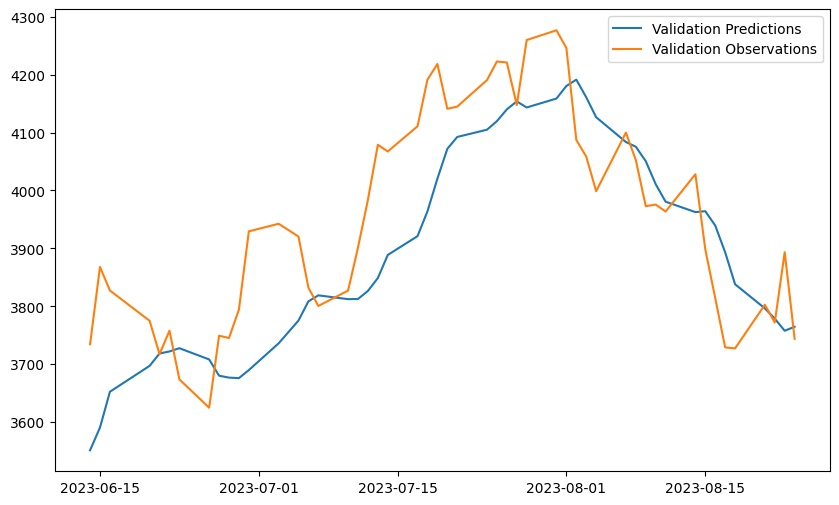

In [85]:
val_predictions = model.predict(X_val).flatten()

val_predictions = pd.DataFrame(val_predictions).apply(denormalize)
Y_val = pd.DataFrame(Y_val).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.legend(["Validation Predictions", "Validation Observations"])

2/2 [==============================] - 0s 11ms/step


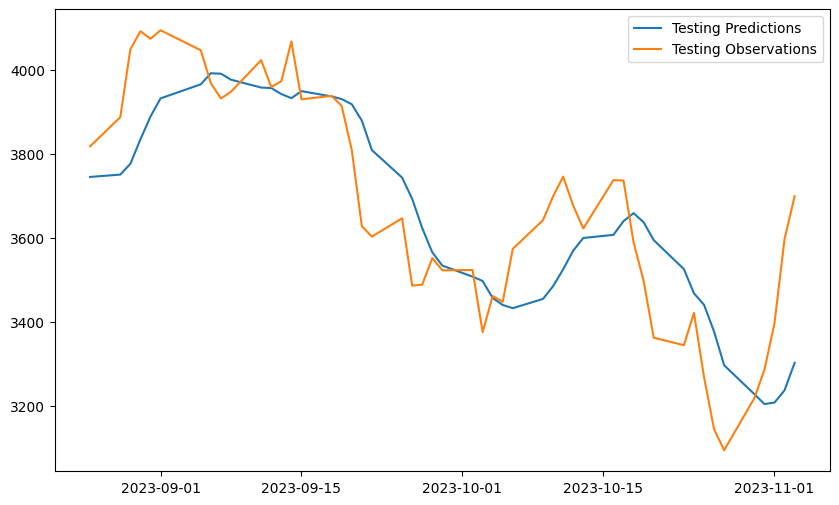

In [86]:
test_predictions = model.predict(X_test).flatten()

test_predictions = pd.DataFrame(test_predictions).apply(denormalize)
Y_test = pd.DataFrame(Y_test).apply(denormalize)

plt.figure(figsize=(10,6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.legend(["Testing Predictions", "Testing Observations"])

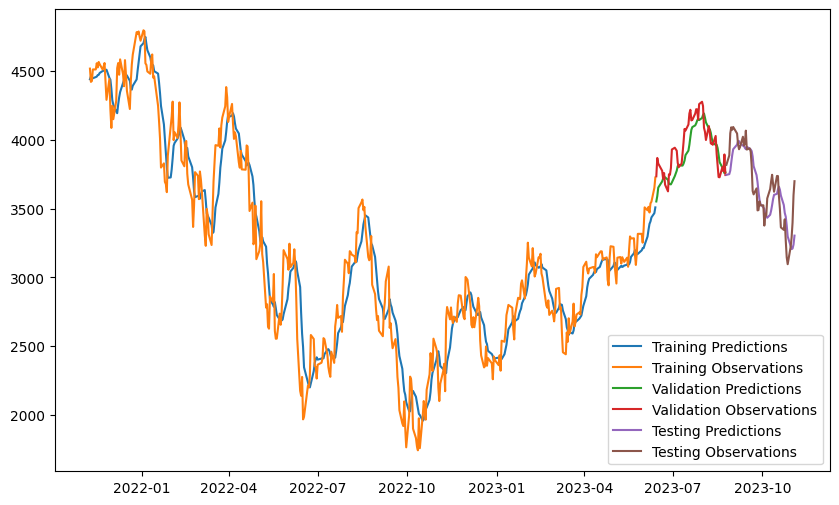

In [87]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)

plt.legend([
    "Training Predictions",
    "Training Observations",
    "Validation Predictions",
    "Validation Observations",
    "Testing Predictions",
    "Testing Observations"
])

In [88]:
from copy import deepcopy
import numpy as np

recursive_predictions = []
recursive_dates = dates_test

last_window = list(deepcopy(X_val[-1]))

for date in recursive_dates:
  next_prediction = model.predict(np.array([last_window])).flatten()
  last_window.pop(0)
  last_window.append(next_prediction[0])
  recursive_predictions.append(next_prediction[0])

recursive_predictions = pd.DataFrame(recursive_predictions).apply(denormalize)

1/1 [==============================] - 0s 24ms/step


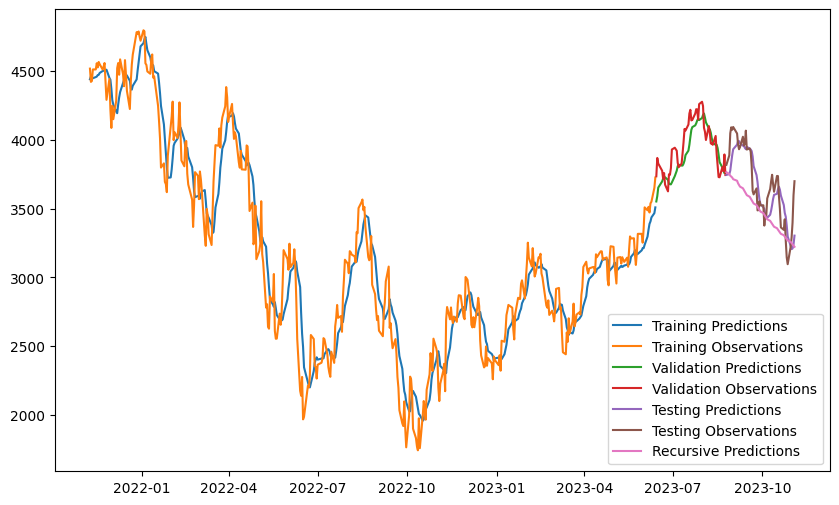

In [89]:
plt.figure(figsize=(10,6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, Y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, Y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, Y_test)
plt.plot(recursive_dates, recursive_predictions)

plt.legend([
    "Training Predictions",
    "Training Observations",
    "Validation Predictions",
    "Validation Observations",
    "Testing Predictions",
    "Testing Observations",
    "Recursive Predictions"
])

## Evaluation Metrics:

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("For the Testing Prediction curve")
print("Mean Absolute Error: ", mean_absolute_error(y_true=Y_test, y_pred=test_predictions))
print("Mean Square Error: ", mean_squared_error(y_true=Y_test, y_pred=test_predictions))
print()

print("For the Recursive Prediction curve:")
print("Mean Absolute Error: ", mean_absolute_error(y_true=Y_test, y_pred=recursive_predictions))
print("Mean Square Error: ", mean_squared_error(y_true=Y_test, y_pred=recursive_predictions))

For the Testing Prediction curve
Mean Absolute Error:  123.0107636478134
Mean Square Error:  24288.923488335768

For the Recursive Prediction curve:
Mean Absolute Error:  210.31109427676944
Mean Square Error:  63643.808878457436
